In [1]:
import torch
from torch import nn
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
    
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import AG_NEWS

from torchsummary import summary

from collections import defaultdict

from PIL import Image
import albumentations as A
from tqdm import tqdm_notebook
import typing as tp
import pathlib

import pandas as pd
import numpy as np

import gc

OSError: /home/victor/.local/lib/python3.8/site-packages/torchtext/lib/libtorchtext.so: undefined symbol: _ZN5torch3jit21setUTF8DecodingIgnoreEb

In [5]:
tokenizer = get_tokenizer("basic_english")
train_iter = AG_NEWS(split="train")


def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [6]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [7]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets


train_iter = AG_NEWS(split="train")
dataloader = DataLoader(train_iter, batch_size=8, shuffle=True, collate_fn=collate_batch)

In [12]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class, layers=3):
        super(LSTM, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.net = nn.LSTM(embed_dim, hidden_size=hidden_dim, num_layers=layers)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        z, (h1, h2) = self.net(embedded)
        # print(z)
        return self.fc(z)


class GRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_class, layers=3):
        super(GRU, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.net = nn.GRU(embed_dim, hidden_size=hidden_dim, num_layers=layers)
        self.fc = nn.Linear(hidden_dim, num_class)

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        z, _ = self.net(embedded)
        # print(z)
        return self.fc(z)


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output


def plot_loss(values, batch_size: int, lr: float, title_prefix: str):
    clear_output()
    with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
        train_loss = values["train_loss"]
        n = len(train_loss)

        plt.figure(figsize=(20, 10))

        plt.suptitle(f"{title_prefix}, batch size {batch_size}, learning rate {lr:.4f}")

        plt.subplot(2, 2, 1)
        plt.plot(range(1, n + 1), train_loss)
        plt.title('Train loss')
        plt.xlabel("Iterations")

        plt.subplot(2, 2, 2)
        error = values["noise_grad"]
        plt.plot(range(1, n + 1), error)
        plt.title(r'$\delta$ - noise magnitude')

        plt.subplot(2, 2, 3)
        alpha = [r / g for r, g in zip(values["noise_grad"], values["full_grad"])]
        plt.plot(range(1, n + 1), alpha)
        plt.title(r'$\alpha$ - relative noise coefficient')
        plt.xlabel("Iterations")

        plt.subplot(2, 2, 4)
        gamma = values["cosinus_grad"]
        plt.plot(range(1, n + 1), gamma)
        plt.title(r'$\gamma$ - cosine coefficient')
        plt.xlabel("Iterations")

        plt.show()


def get_list_grad_params(net: nn.Module) -> tp.List[torch.Tensor]:
    return [param.grad.detach().cpu() for param in net.parameters() if param.grad is not None]

def calc_grad_info(net: nn.Module, info: tp.List[torch.Tensor]):
    new_grads = get_list_grad_params(net)
    if not info:
        return new_grads
    return [new_grad + cur_grad for new_grad, cur_grad in zip(new_grads, info)]

def get_dif(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    return [grad_1 - grad_2 for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]

def mult_grad(info: tp.List[torch.Tensor], mult: float):
    return [grad * mult for grad in info] 

def get_grad_norm(grads: tp.List[torch.Tensor]):
    return np.sqrt(sum(grad.norm().item() ** 2 for grad in grads))

def get_cosinus_grad(grad_info_1: tp.List[torch.Tensor], grad_info_2: tp.List[torch.Tensor]) -> tp.List[torch.Tensor]:
    sc = sum([(grad_1 * grad_2).sum() for grad_1, grad_2 in zip(grad_info_1, grad_info_2)]).item()
    return sc / get_grad_norm(grad_info_1) / get_grad_norm(grad_info_2)


def calc_matrix_cosinus(grads: tp.List[tp.List[torch.Tensor]]):
    a = [[0 for i in range(len(grads))] for j in range(len(grads))]
    for i in range(len(grads)):
        for j in range(len(grads)):
            a[i][j] = get_cosinus_grad(grads[i], grads[j])
    return a


In [10]:
def train_cycle(
    model,
    optim,
    criterion,
    epochs,
    device,
    dataloader,
    mult: float,
    verbose=True,
    bound_batches = None,
    step: int = 1,
    output_data: dict = None
):
    history = defaultdict(list)

    for _ in range(epochs):
        model.train()
        
        full_grad = []
        cur_grad = []
        for y, x, offset in tqdm_notebook(dataloader):
            optim.zero_grad()
            x = x.to(device)
            offset = offset.to(device).type(torch.int)
            logits = model(x, offset)
            y_ = y.to(device)
            # print(logits, logits)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            # optim.step()
            del x
            del offset
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()

        history["estimation_grad"].append(get_grad_norm(cur_grad))
        history["full_grad"].append(get_grad_norm(full_grad))
        history["noise_grad"].append(get_grad_norm(get_dif(full_grad, cur_grad)))
        history["cosinus_grad"].append(get_cosinus_grad(cur_grad, full_grad))
        optim.step()
        loss_ = loss_batch.detach().item()
        history["train_loss"].append(loss_)
        
        if verbose:
            plot_loss(history,
                      batch_size=output_data["batch_size"],
                      lr=output_data["lr"],
                      title_prefix=output_data["title_prefix"])

    return model, history

In [ ]:
def train_cycle(
    model,
    optim,
    criterion,
    epochs,
    device,
    dataloader,
    mult: float,
    verbose=True,
    bound_batches = None,
    single_loader = None,
    step: int = 1,
    output_data: dict = None
):
    history = defaultdict(list)

    for _ in range(epochs):
        model.train()
        
        full_grad = []
        cur_grad = []
        K = 50
        k = 0

        grads = []

        for x, y in tqdm_notebook(single_loader):
            k += 1
            optim.zero_grad()
            x = x.to(device).type(torch.float32)
            logits = model(x)
            y_ = y.to(device)
            # print(logits, logits)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            # full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            grads.append(cur_grad)
            del x
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()
            if k == K:
                break
        
        history["cosine_distr"].append(calc_matrix_cosinus(grads))
        del grads

        for x, y in tqdm_notebook(dataloader):
            optim.zero_grad()
            x = x.to(device).type(torch.float32)
            logits = model(x)
            y_ = y.to(device)
            # print(logits, logits)
            loss_batch = criterion(logits, y_)
            loss_batch.backward()
            optim.step()
            full_grad = calc_grad_info(model, full_grad)
            cur_grad = mult_grad(get_list_grad_params(model), mult=mult)
            del x
            del y
            if 'cuda' in device:
                torch.cuda.synchronize()
                torch.cuda.empty_cache()
                gc.collect()

        history["estimation_grad"].append(get_grad_norm(cur_grad))
        history["full_grad"].append(get_grad_norm(full_grad))
        history["noise_grad"].append(get_grad_norm(get_dif(full_grad, cur_grad)))
        history["cosinus_grad"].append(get_cosinus_grad(cur_grad, full_grad))
        # optim.step()
        loss_ = loss_batch.detach().item()
        history["train_loss"].append(loss_)
        
        if verbose:
            plot_loss(history,
                      batch_size=output_data["batch_size"],
                      lr=output_data["lr"],
                      title_prefix=output_data["title_prefix"])

    return model, history

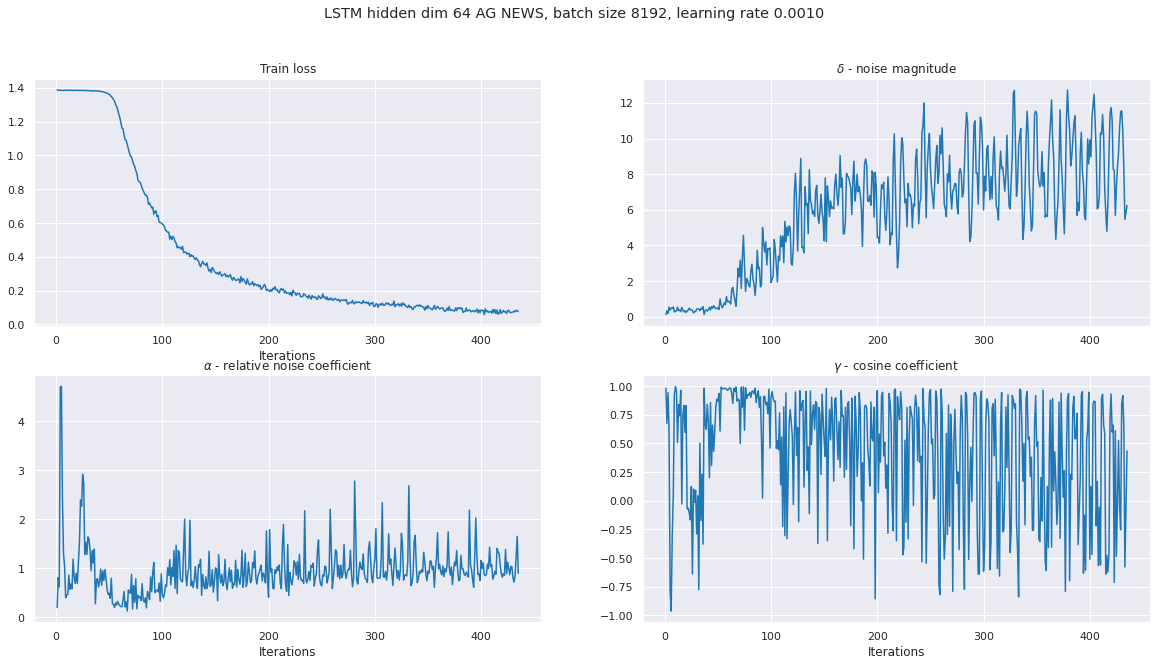

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [11]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_iter = AG_NEWS(split="train")
num_class = 4
vocab_size = len(vocab)
dataset_size = 120000
emsize = 128
hidden_dim = 64
model = LSTM(vocab_size, emsize, hidden_dim, num_class)

batch_size: int = 8192
workers: int = 6
learning_rate = 1e-3

output_data = {
    "batch_size": batch_size,
    "lr": learning_rate,
    "title_prefix": f"LSTM hidden dim {hidden_dim} AG NEWS"
}

dataloader_train = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, num_workers=workers)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
verbose = True

epochs = 3000

model, history = train_cycle(model,
                             optimizer,
                             criterion,
                             epochs,
                             device,
                             dataloader_train,
                             mult=dataset_size / batch_size,
                             output_data=output_data)

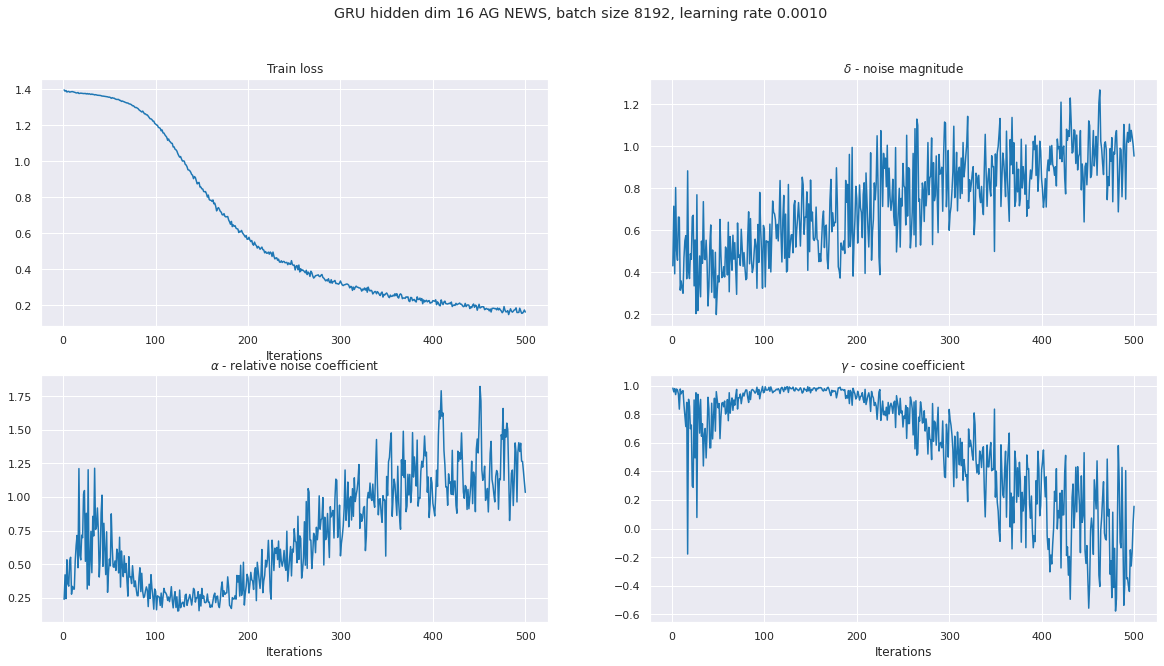

In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_iter = AG_NEWS(split="train")
num_class = 4
vocab_size = len(vocab)
dataset_size = 120000
emsize = 32
hidden_dim = 16
model = GRU(vocab_size, emsize, hidden_dim, num_class, layers=1)

batch_size: int = 8192
workers: int = 6
learning_rate = 1e-3

output_data = {
    "batch_size": batch_size,
    "lr": learning_rate,
    "title_prefix": f"GRU hidden dim {hidden_dim} AG NEWS"
}

dataloader_train = DataLoader(train_iter, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, num_workers=workers)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
verbose = True

epochs = 500

model, history = train_cycle(model,
                             optimizer,
                             criterion,
                             epochs,
                             device,
                             dataloader_train,
                             mult=dataset_size / batch_size,
                             output_data=output_data)

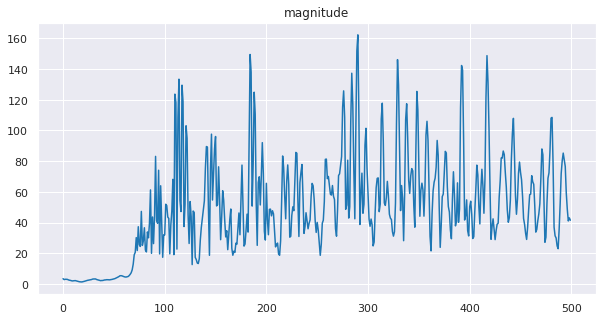

In [66]:
with sns.plotting_context("notebook"), sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 5))

    x =  history["estimation_grad"]
    x = history["full_grad"]

    plt.plot(range(len(x)), x)
    plt.title(r'magnitude')

    plt.show()